#Predictive Analytics - Personal Loans
Abigail McDonald

**Scenario:** Universal Bank is a small local bank with approximately 80,000 checking account customers. Universal Bank would like to offer personal loans secured by home equity to as many customers as possible (loan average \$1000 per customer).  A marketing consultant has proposed a 'no-fee-anywhere' ATM incentive to draw customers into the loan (customers were not obligated to accept the loan, just to complete loan paperwork on acceptance of ATM offer).  After running an experiment with a subset of 4000 customers, the following metrics were gleaned:

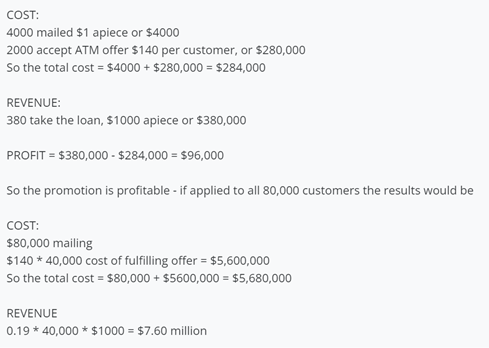

In order to better target the offer, the consultant suggests building a predictive model.

**Defined Business Problem:**  
Universal Bank would like to maximize revenue on its personal loan product.  Using collected customer data, a predictive model can be built to determine whether a customer is likely to accept the personal loan.  The model can then be analyzed against current existing marketing strategies (e.g. the original marketing ATM plan) to determine the most cost effective method. 

##Data Wrangling

In [ ]:
#load libraries
!pip install dmba
%matplotlib inline
import warnings
from pathlib import Path

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier

from dmba import classificationSummary, plotDecisionTree
from dmba import gainsChart, liftChart

sns.set_style('whitegrid')

#call data into data frame
# Load the data
bank_df = pd.read_csv("UniversalBankSample.csv")
bank_df.head()

,ID,Age,Experience,Income,ZIP.Code,Family,CCAvg,Education,Mortgage,Personal.Loan,Securities.Account,CD.Account,Online,CreditCard
0,299,43,19,81,92069,2,3.2,1,0,0,0,0,0,0
1,2588,60,33,55,94998,4,2.5,2,0,0,0,0,1,0
2,1452,44,20,82,94555,4,1.4,2,201,0,0,0,1,1
3,3630,50,26,82,95051,1,0.0,1,0,0,0,0,1,1
4,1540,29,5,21,90601,3,0.9,3,119,0,0,0,0,0


In [ ]:
#clean data: check for and handle inappropriate datatypes, missing data, and unneeded variables
# Drop ID and zip code columns
bank_df = bank_df.drop(columns=['ID', 'ZIP.Code'])

#change datatypes
intColumns = [c for c in bank_df.columns if bank_df[c].dtype == 'int64']
intColumns.remove('Personal.Loan')
bank_df[intColumns] = bank_df[intColumns].astype('float64')

print(bank_df.dtypes)
print("The shape of the data is ", bank_df.shape)

#check for null values
print("Null values by column: ","\n", bank_df.isnull().sum())

Age                   float64
Experience            float64
Income                float64
Family                float64
CCAvg                 float64
Education             float64
Mortgage              float64
Personal.Loan           int64
Securities.Account    float64
CD.Account            float64
Online                float64
CreditCard            float64
dtype: object
The shape of the data is  (4000, 12)
Null values by column:  
 Age                   0
Experience            0
Income                0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal.Loan         0
Securities.Account    0
CD.Account            0
Online                0
CreditCard            0
dtype: int64


##Exploratory Data Analysis

In [ ]:
#statistical analysis and exploration of the cleaned data (general trend plots and descriptive statistics)
bank_df.describe()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal.Loan,Securities.Account,CD.Account,Online,CreditCard
count,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,45.477750,20.24550,73.416500,2.402000,1.925522,1.876500,57.264500,0.095500,0.105500,0.059750,0.606250,0.294750
std,11.424804,11.43667,45.999555,1.142244,1.749129,0.839002,102.605919,0.293941,0.307235,0.237053,0.488642,0.455987
min,23.000000,-3.00000,8.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.750000,10.00000,39.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,46.000000,20.00000,63.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,55.000000,30.00000,95.000000,3.000000,2.500000,3.000000,102.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,67.000000,43.00000,224.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.000000,1.000000,1.000000


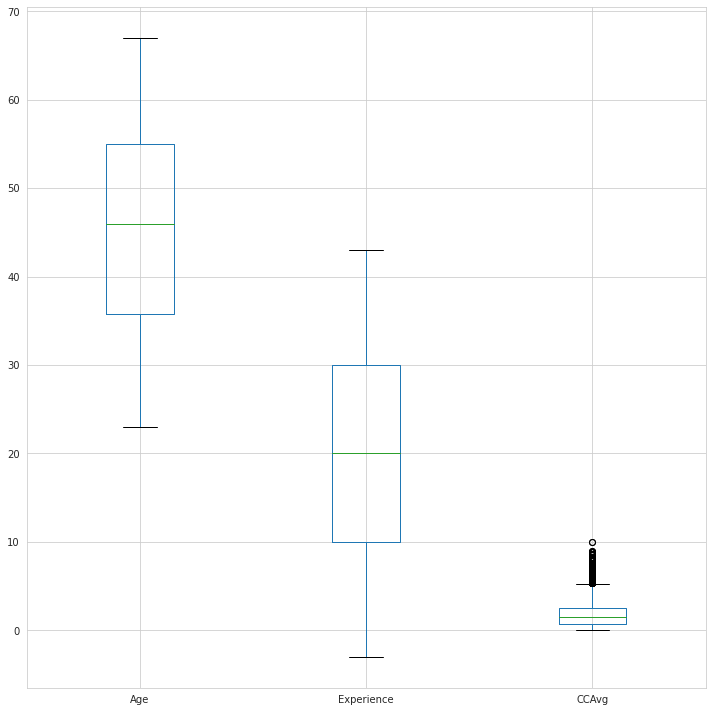

In [ ]:
fig, axes = plt.subplots(figsize=(10, 10))
col1 = ['Age', 'Experience', 'CCAvg']
bank_df.boxplot(column=col1)
plt.tight_layout()
plt.show()

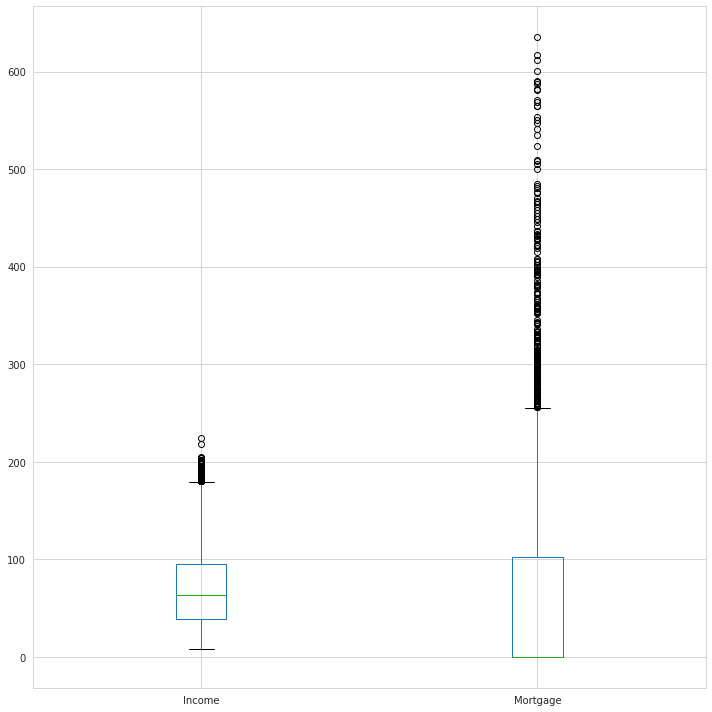

In [ ]:
fig, axes = plt.subplots(figsize=(10, 10))
col2 = ['Income','Mortgage']
bank_df.boxplot(column=col2)
plt.tight_layout()
plt.show()

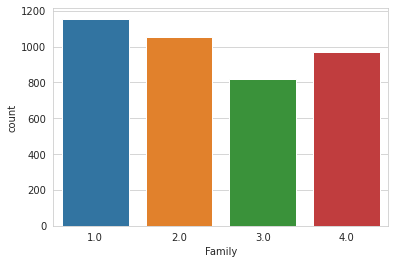

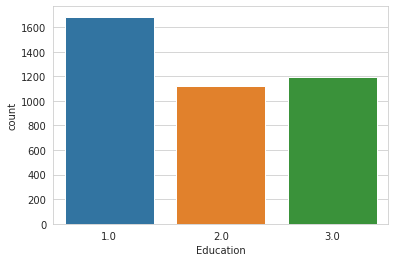

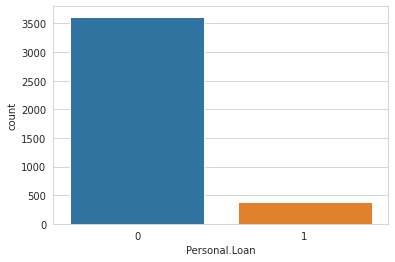

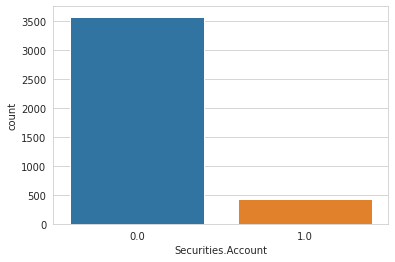

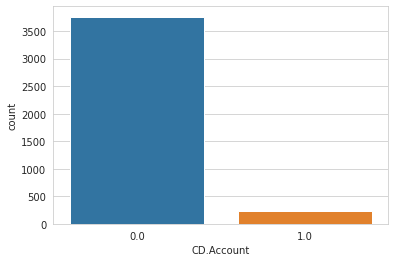

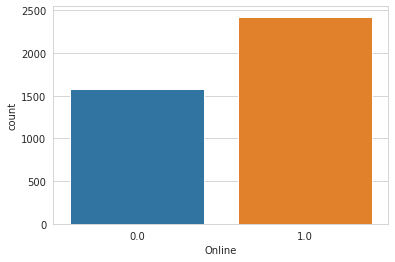

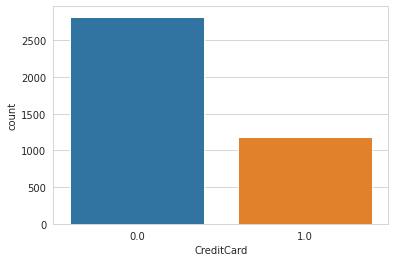

In [ ]:
import warnings

import warnings
warnings.filterwarnings("ignore")

l=['Family', 'Education', 'Personal.Loan', 'Securities.Account', 'CD.Account', 'Online', 'CreditCard']
for i in l:
    sns.countplot(bank_df[i])
    plt.show()

##Modeling

###Data Preparation

In [ ]:
#train/test split
X = bank_df.drop(columns='Personal.Loan')
y = bank_df['Personal.Loan']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (2400, 11) Validation set: (1600, 11)


###Basic predictive model

In [ ]:
#run a simple classification model (full tree), plot it and evaluate its accuracy (benchmark)
classTree = DecisionTreeClassifier(random_state=1)
classTree.fit(train_X, train_y)

print('Tree has {} nodes'.format(classTree.tree_.node_count), '\n')

print(classificationSummary(valid_y, classTree.predict(valid_X)), '\n')

print(classification_report(valid_y, classTree.predict(valid_X)))

Tree has 93 nodes 

Confusion Matrix (Accuracy 0.9769)

       Prediction
Actual    0    1
     0 1425   19
     1   18  138
None 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1444
           1       0.88      0.88      0.88       156

    accuracy                           0.98      1600
   macro avg       0.93      0.94      0.93      1600
weighted avg       0.98      0.98      0.98      1600



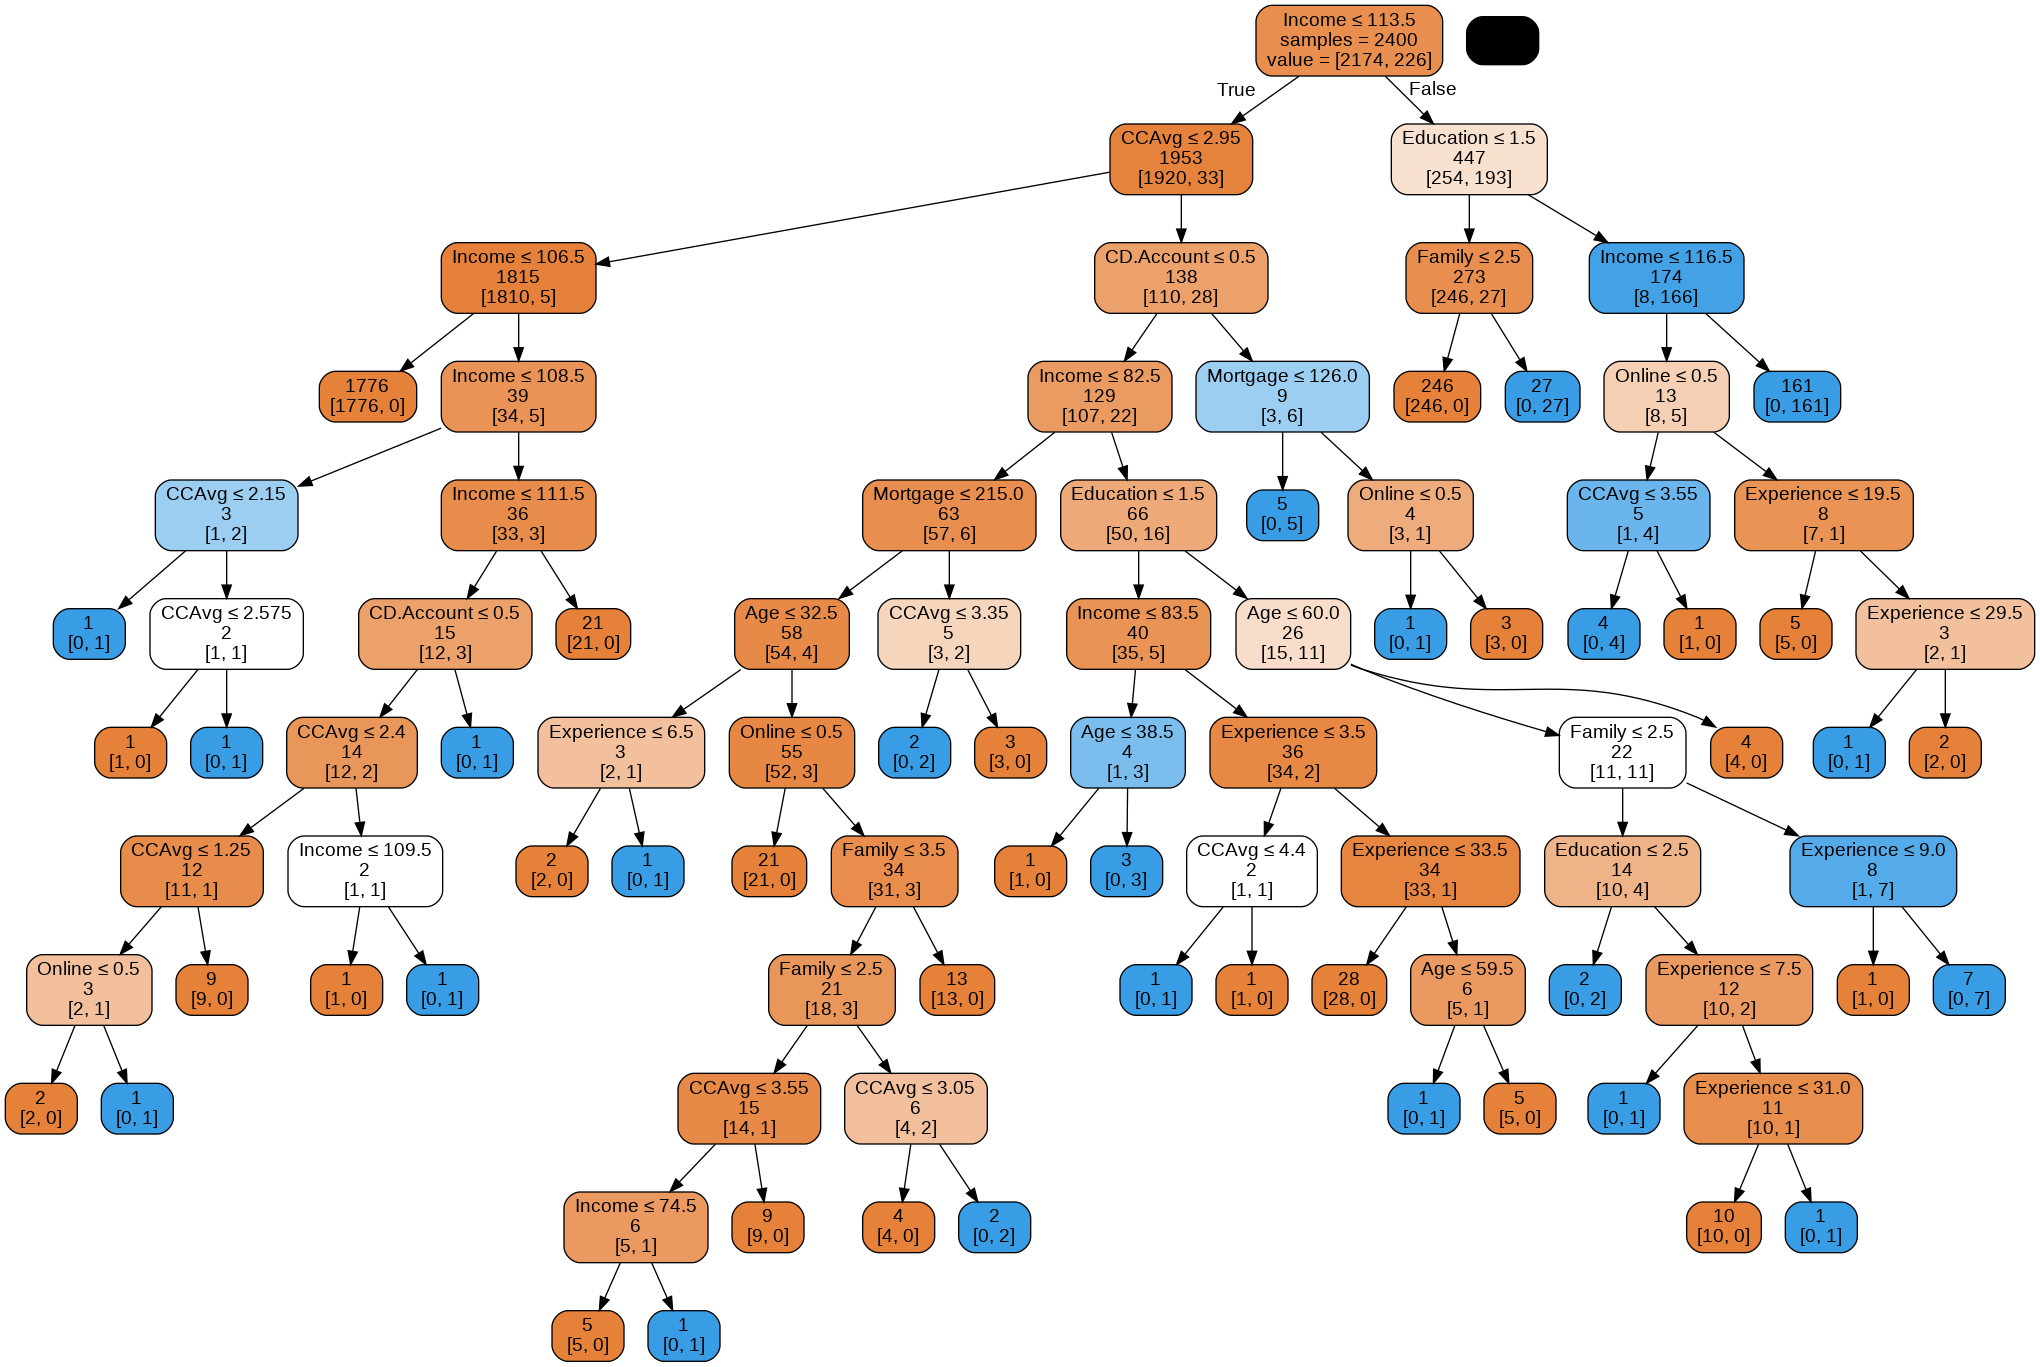

In [ ]:
plotDecisionTree(classTree, feature_names=train_X.columns, impurity=False)

Income appears to have the largest impact on prediction.

###Ensemble predictive models

####Boosted Tree Model

In [ ]:
boost = AdaBoostClassifier(n_estimators=100, base_estimator=classTree, random_state=1)
boost.fit(train_X, train_y)

print(classificationSummary(valid_y, boost.predict(valid_X)), '\n')

print(classification_report(valid_y, boost.predict(valid_X)))


Confusion Matrix (Accuracy 0.9781)

       Prediction
Actual    0    1
     0 1427   17
     1   18  138
None 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1444
           1       0.89      0.88      0.89       156

    accuracy                           0.98      1600
   macro avg       0.94      0.94      0.94      1600
weighted avg       0.98      0.98      0.98      1600



####Bagged Tree Model

In [ ]:
bagging = BaggingClassifier(classTree, max_samples=0.5, max_features=0.5, random_state=1)
bagging.fit(train_X, train_y)

print(classificationSummary(valid_y, bagging.predict(valid_X)), '\n')

print(classification_report(valid_y, bagging.predict(valid_X)))

Confusion Matrix (Accuracy 0.9294)

       Prediction
Actual    0    1
     0 1439    5
     1  108   48
None 

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1444
           1       0.91      0.31      0.46       156

    accuracy                           0.93      1600
   macro avg       0.92      0.65      0.71      1600
weighted avg       0.93      0.93      0.91      1600



####Random Forest Model

In [ ]:
rfModel = RandomForestClassifier(random_state=1, n_estimators=100)
rfModel.fit(train_X, train_y)

print(classificationSummary(valid_y, rfModel.predict(valid_X)), '\n')

print(classification_report(valid_y, rfModel.predict(valid_X)))

Confusion Matrix (Accuracy 0.9850)

       Prediction
Actual    0    1
     0 1442    2
     1   22  134
None 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1444
           1       0.99      0.86      0.92       156

    accuracy                           0.98      1600
   macro avg       0.99      0.93      0.95      1600
weighted avg       0.99      0.98      0.98      1600



###Final Model Prediction

In [ ]:
#Random Forest Model (highest accuracy, highest f-1 score for both True and False)
final = RandomForestClassifier(random_state=1, n_estimators=100)
final.fit(X, y)

print(classificationSummary(y, final.predict(X)), '\n')

print(classification_report(y, final.predict(X)))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 3618    0
     1    0  382
None 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3618
           1       1.00      1.00      1.00       382

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



##Final Cost Analysis

###Technical Analysis
The deep tree model was remarkably accurate at 0.9769, but overpredicted non-acceptors at an f-1 of 0.88.  This was minimized in the random forest model, whose overall accuracy was 0.9850 and had an improved non-acceptor f-1 score of 0.92.  This will lead to 22 of the validation set of customers being overlooked and 2 being inaccurately predicted to take the loan. 

###Business Analysis
1442 out of 1600 = 90.125% correctly predicted to not accept the loan
> *When extrapolated to the full 80,000 customer dataset, it would be 72,100 customers*

134 out of 1600 = 8.375% correctly predicted to accept the loan
> *When extrapolated to the full 80,000 customer dataset, it would be 6,700 customers*

2 out of 1600 = 0.125% incorrectly predicted to accept the loan (did not accept, lost mailing expenses)
> *When extrapolated to the full 80,000 customer dataset, it would be 100 customers*

22 out of 1600 = 1.375% incorrectly predicted to not accept the loan (not offered, lost revenue)
> *When extrapolated to the full 80,000 customer dataset, it would be 1,100 customers*


The targeted (predicted customer) revenue breakdown would be as follows:

COST: (all customers predicted to accept loan)
> (6,700 (correctly) +100 (incorrectly)) x $1 = $6800

\*assuming the AD scheme is offered to all predicted customers and all accept (there is no data for this)
> 6,800 x 140 = $952,000

Total cost (mailing + targeted AD scheme):
> 6800 + 952,000 = $958,800

REVENUE: (only customers who were offered and accepted the loan)
> (6,700 x 1,000) = 6.7 million

PROFIT for targeted model: (revenue – total cost)
> 6.7 million - 958,800 = 5,741,200


PROFIT for original marketing AD scheme:
> 7.6 million - 5.68 million  = 1.92 million

Using the Predictive model was 2.99 times more profitable than the ad scheme even with the potential lost revenue of 1,100 customers the model missed.  The ad scheme cost for targeted customers cannot be accurately predicted because the data is not available in the dataset.  However, the highest payout was assumed, so the profit can only increase.


##Conclusion
The predictive Random Forest model is the best way for the bank to maximize its revenue.  It had a profit 2.99 times greater than the proposed marketing Ad scheme.  In the future, with a larger data set, it would be good to try to improve the performance of the model to eliminate as many of the missed customers as possible.  Additionally, some of the original data needs to be tracked down.  There is negative experience for some customers in the experience column; this would need to be discussed with the stakeholder.  Additionally, there is no data in the dataset for those who accepted the ATM offer.  To make a stronger predictive model, this needs to be a variable in the original dataset.